## Домашнее задание

#### Задача

##### Понять почему 30-дневный прогноз цены на криптовалюту резко падает или вовсе не совпадает с реальными данными, визуализировать процессы обучения и сделать выводы.

#### Подсказки

1. Модели не учитывают важные факторы или данных для обучения недостаточно. Использовались ли только исторические цены закрытия, или были добавлены другие признаки? Данные включают только столбец `Close`, что ограничивает модель в изучении других факторов, влияющих на цену.
2. Проблема связана с нормализацией данных. Использовался `MinMaxScaler` в диапазоне $(0,1)$. Если последние значения в последовательности близки к **1**, то прогнозируемые значения могут выходить за пределы этого диапазона, что приводит к некорректным предсказаниям после обратного преобразования. Стоит попробовать другие методы нормализации или масштабирования.
3. Проверить, как реализовано прогнозирование на несколько шагов вперед. Функция `forecast` предсказывает каждый следующий день, добавляя его в последовательность. Однако накопление ошибок может привести к ошибке предсказаний. Нужно обратить внимание на то, как модель обрабатывает многократные предсказания: возможно, она начинает предсказывать среднее значение или шум после нескольких шагов.
4. Проверить качество обучения модели. Если модель недообучена или переобучена, то прогнозы будут неточными. Нужно посмотреть на график потерь во время обучения. Попробовать увеличить количество эпох, изменить скорость обучения или заменить функцию активации.
5. Проверить разделение данных на обучающую и тестовую выборки. Если тестовая выборка содержит необычные шаблоны или выбросы, модель будет плохо на них реагировать. Убедиться, что данные разделены правильно и временные зависимости учтены корректно.
6. Неадекватная архитектура модели. Проверить увеличение количества нейронов или слоев.
7. Обратить внимание на длину последовательности (`seq_length`). Если окно слишком большое или маленькое, модель будет не улавливать нужные зависимости.
8. Может проблема в самом характере данных? Цены волатильны и подвержены влиянию внешних факторов, которые не учтены в модели.
9. Может ошибки в коде?

In [1]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

## Процесс обучения GRU

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.000692
Epoch 10, Loss: 0.000300


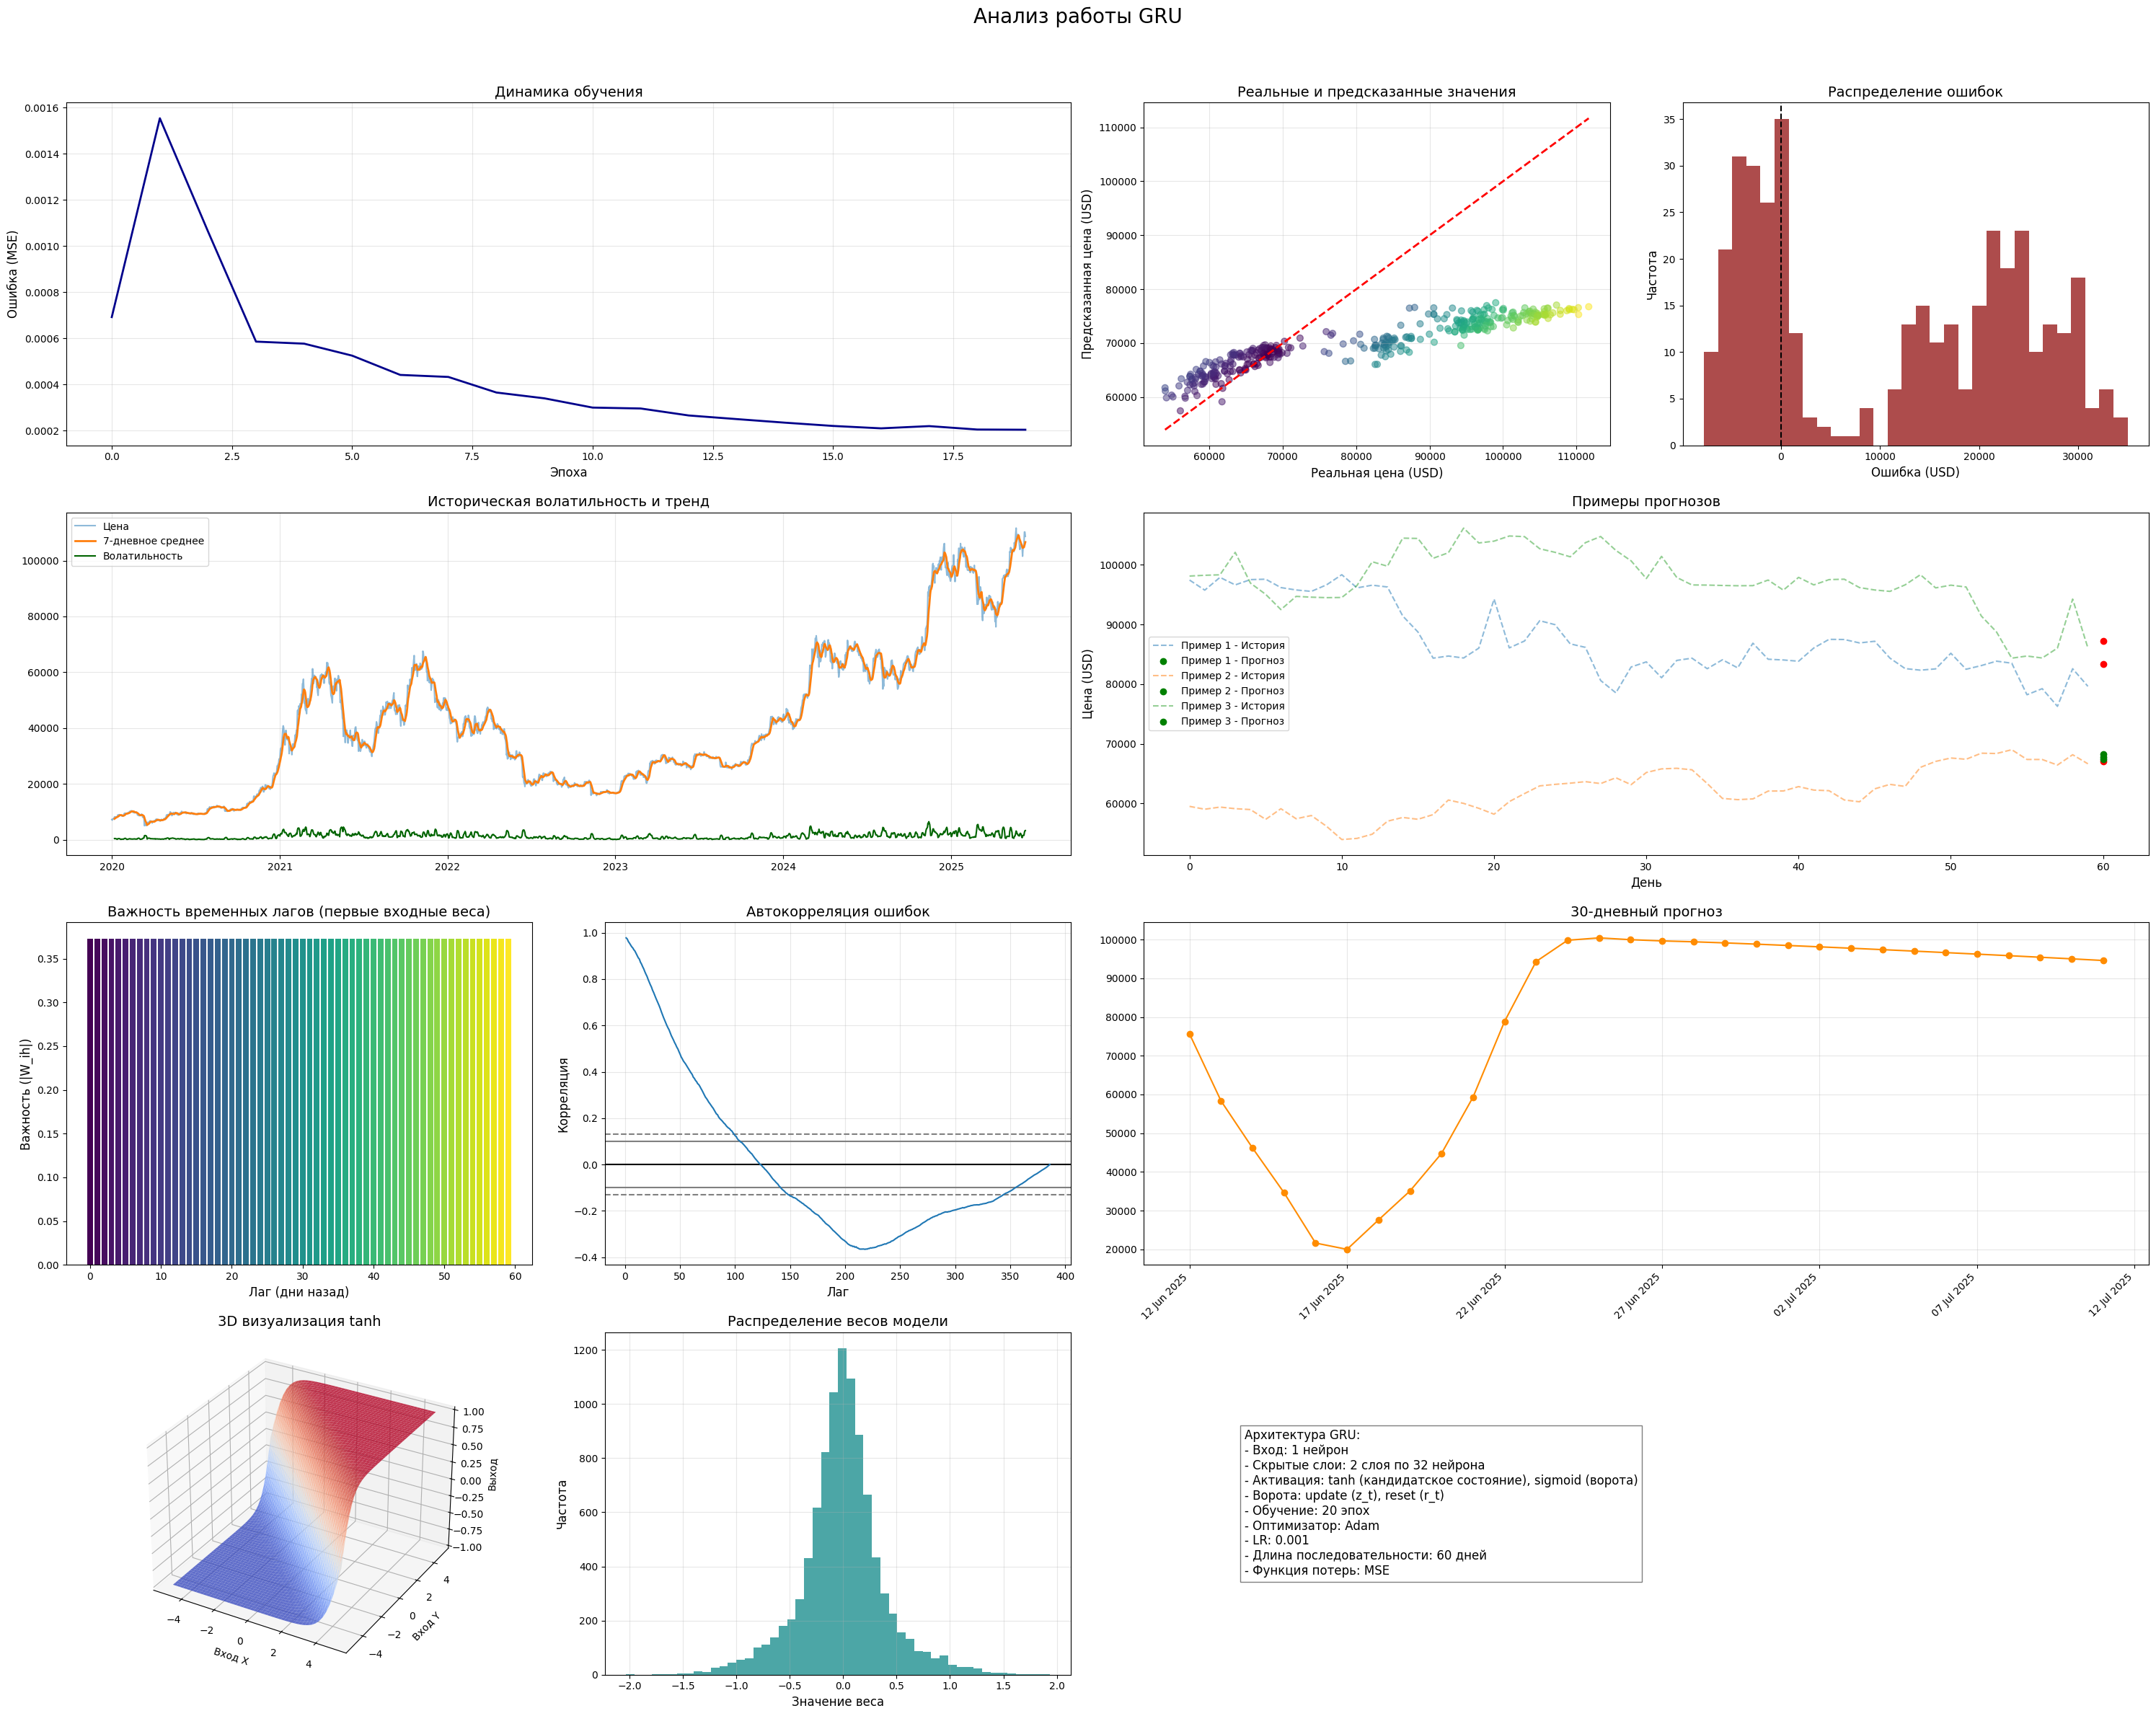

In [2]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return torch.FloatTensor(X), torch.FloatTensor(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Определение GRU модели
class BitcoinGRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinGRU()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Обучение модели
num_epochs = 20
train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for i in range(len(X_train)):
        inputs = X_train[i].unsqueeze(0)
        target = y_train[i].unsqueeze(0)
        
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(X_train)
    train_loss.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

# Прогнозирование
def forecast(model, sequence, days = 30):
    current_seq = sequence.squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        predictions.append(pred.item())
        current_seq = torch.cat((current_seq[1:], pred))
    return predictions

# Генерация прогноза
last_sequence = scaled_data[-seq_length:]
input_tensor = torch.FloatTensor(last_sequence).unsqueeze(0)
scaled_forecast = forecast(model, input_tensor, days = 30)
forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

# Преобразование предсказаний и тестовых данных
model.eval()
test_predictions = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0))
        test_predictions.append(pred.item())

test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Создание единой фигуры с subplots
plt.figure(figsize = (30, 25))
plt.suptitle("Анализ работы GRU", y = 0.95, fontsize = 20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
ax1.plot(train_loss, color = "darkblue", linewidth = 2)
ax1.set_title("Динамика обучения", fontsize = 14)
ax1.set_xlabel("Эпоха", fontsize = 12)
ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
ax1.grid(True, alpha = 0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
ax2.scatter(y_test_original, test_predictions, alpha = 0.5, c = np.abs(y_test_original - test_predictions), cmap = "viridis", s = 40)
ax2.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], "--r", linewidth = 2)
ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
ax2.grid(alpha = 0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_original - test_predictions
ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
ax3.set_title("Распределение ошибок", fontsize = 14)
ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
ax3.set_ylabel("Частота", fontsize = 12)
ax3.axvline(x = 0, color = "black", linestyle = "--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
ax4.plot(data["Close"], label = "Цена", alpha = 0.5)
ax4.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
ax4.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize = 14)
ax4.legend()
ax4.grid(alpha = 0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan = 2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = scaler.inverse_transform(y_test[idx].numpy().reshape(-1, 1))
    
    ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color = "red", zorder = 5)
    ax5.scatter(len(seq), scaler.inverse_transform(pred.numpy()), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize = 14)
ax5.set_xlabel("День", fontsize = 12)
ax5.set_ylabel("Цена (USD)", fontsize = 12)
ax5.legend()

# 6. Важность временных лагов (адаптированная для GRU)
ax6 = plt.subplot2grid((4, 4), (2, 0))
# Получаем веса входного слоя GRU
gru_weights = model.gru.weight_ih_l0.detach().numpy()
# Средние значения весов по всем нейронам
lag_importance = np.mean(np.abs(gru_weights[:model.hidden_size]), axis = 0)
ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))
ax6.set_title("Важность временных лагов (первые входные веса)", fontsize = 14)
ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize = 12)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
ax7.set_title("Автокорреляция ошибок", fontsize = 14)
ax7.set_xlabel("Лаг", fontsize = 12)
ax7.set_ylabel("Корреляция", fontsize = 12)
ax7.grid(alpha = 0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan = 2)
forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
ax8.set_title("30-дневный прогноз", fontsize = 14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
ax8.grid(True, alpha = 0.3)

# 9. 3D визуализация функции активации
ax9 = plt.subplot2grid((4, 4), (3, 0), projection = "3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.tanh(X + Y)
ax9.plot_surface(X, Y, Z, cmap = "coolwarm", alpha = 0.8)
ax9.set_title("3D визуализация tanh", fontsize = 14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
ax10.set_title("Распределение весов модели", fontsize = 14)
ax10.set_xlabel("Значение веса", fontsize = 12)
ax10.set_ylabel("Частота", fontsize = 12)
ax10.grid(True, alpha = 0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan = 2)
ax11.axis("off")
text = """Архитектура GRU:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (кандидатское состояние), sigmoid (ворота)
- Ворота: update (z_t), reset (r_t)
- Обучение: 20 эпох
- Оптимизатор: Adam
- LR: 0.001
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

plt.tight_layout(rect = [0, 0, 1, 0.93])
plt.show()

### Решение

Проблемы исходной реализации:
- Исходно GRU обучался только на одном признаке (цене закрытия)
- Также не использовалась регуляризация
- Масштабирование данных делалось по всему датасету целиком (имеется утечка информации из тестовой части)
- Модель обучалась по одному примеру за раз (без батчей)
- Модель обучалась без Dropout, что могло привести к переобучению. 

В результате на трейне получалось очень низкий Loss ~0.0003, что может указывать на слишком сильную подгонку под данные


Методы улучшения:
- Добавить новые признаки: в модель можно добавить объём торгов и технические индикаторы (RSI, MACD и т.п.) 
- Исправить масштабирование: чтобы избежать утечки информации, масштабирование (`MinMaxScaler`) нужно обучить только на тренировочных данных, а затем применять к тестовым
- Регуляризация и обучение: добавить в модель Dropout. Можно также повысить число эпох и использовать мини-батчи вместо одиночных сэмплов 

Напишем новый код и оценим новое качество на графиках

[*********************100%***********************]  1 of 1 completed


Epoch 0, Loss: 0.068802
Epoch 10, Loss: 0.002423
Epoch 20, Loss: 0.001963
Epoch 30, Loss: 0.001445
Epoch 40, Loss: 0.001481


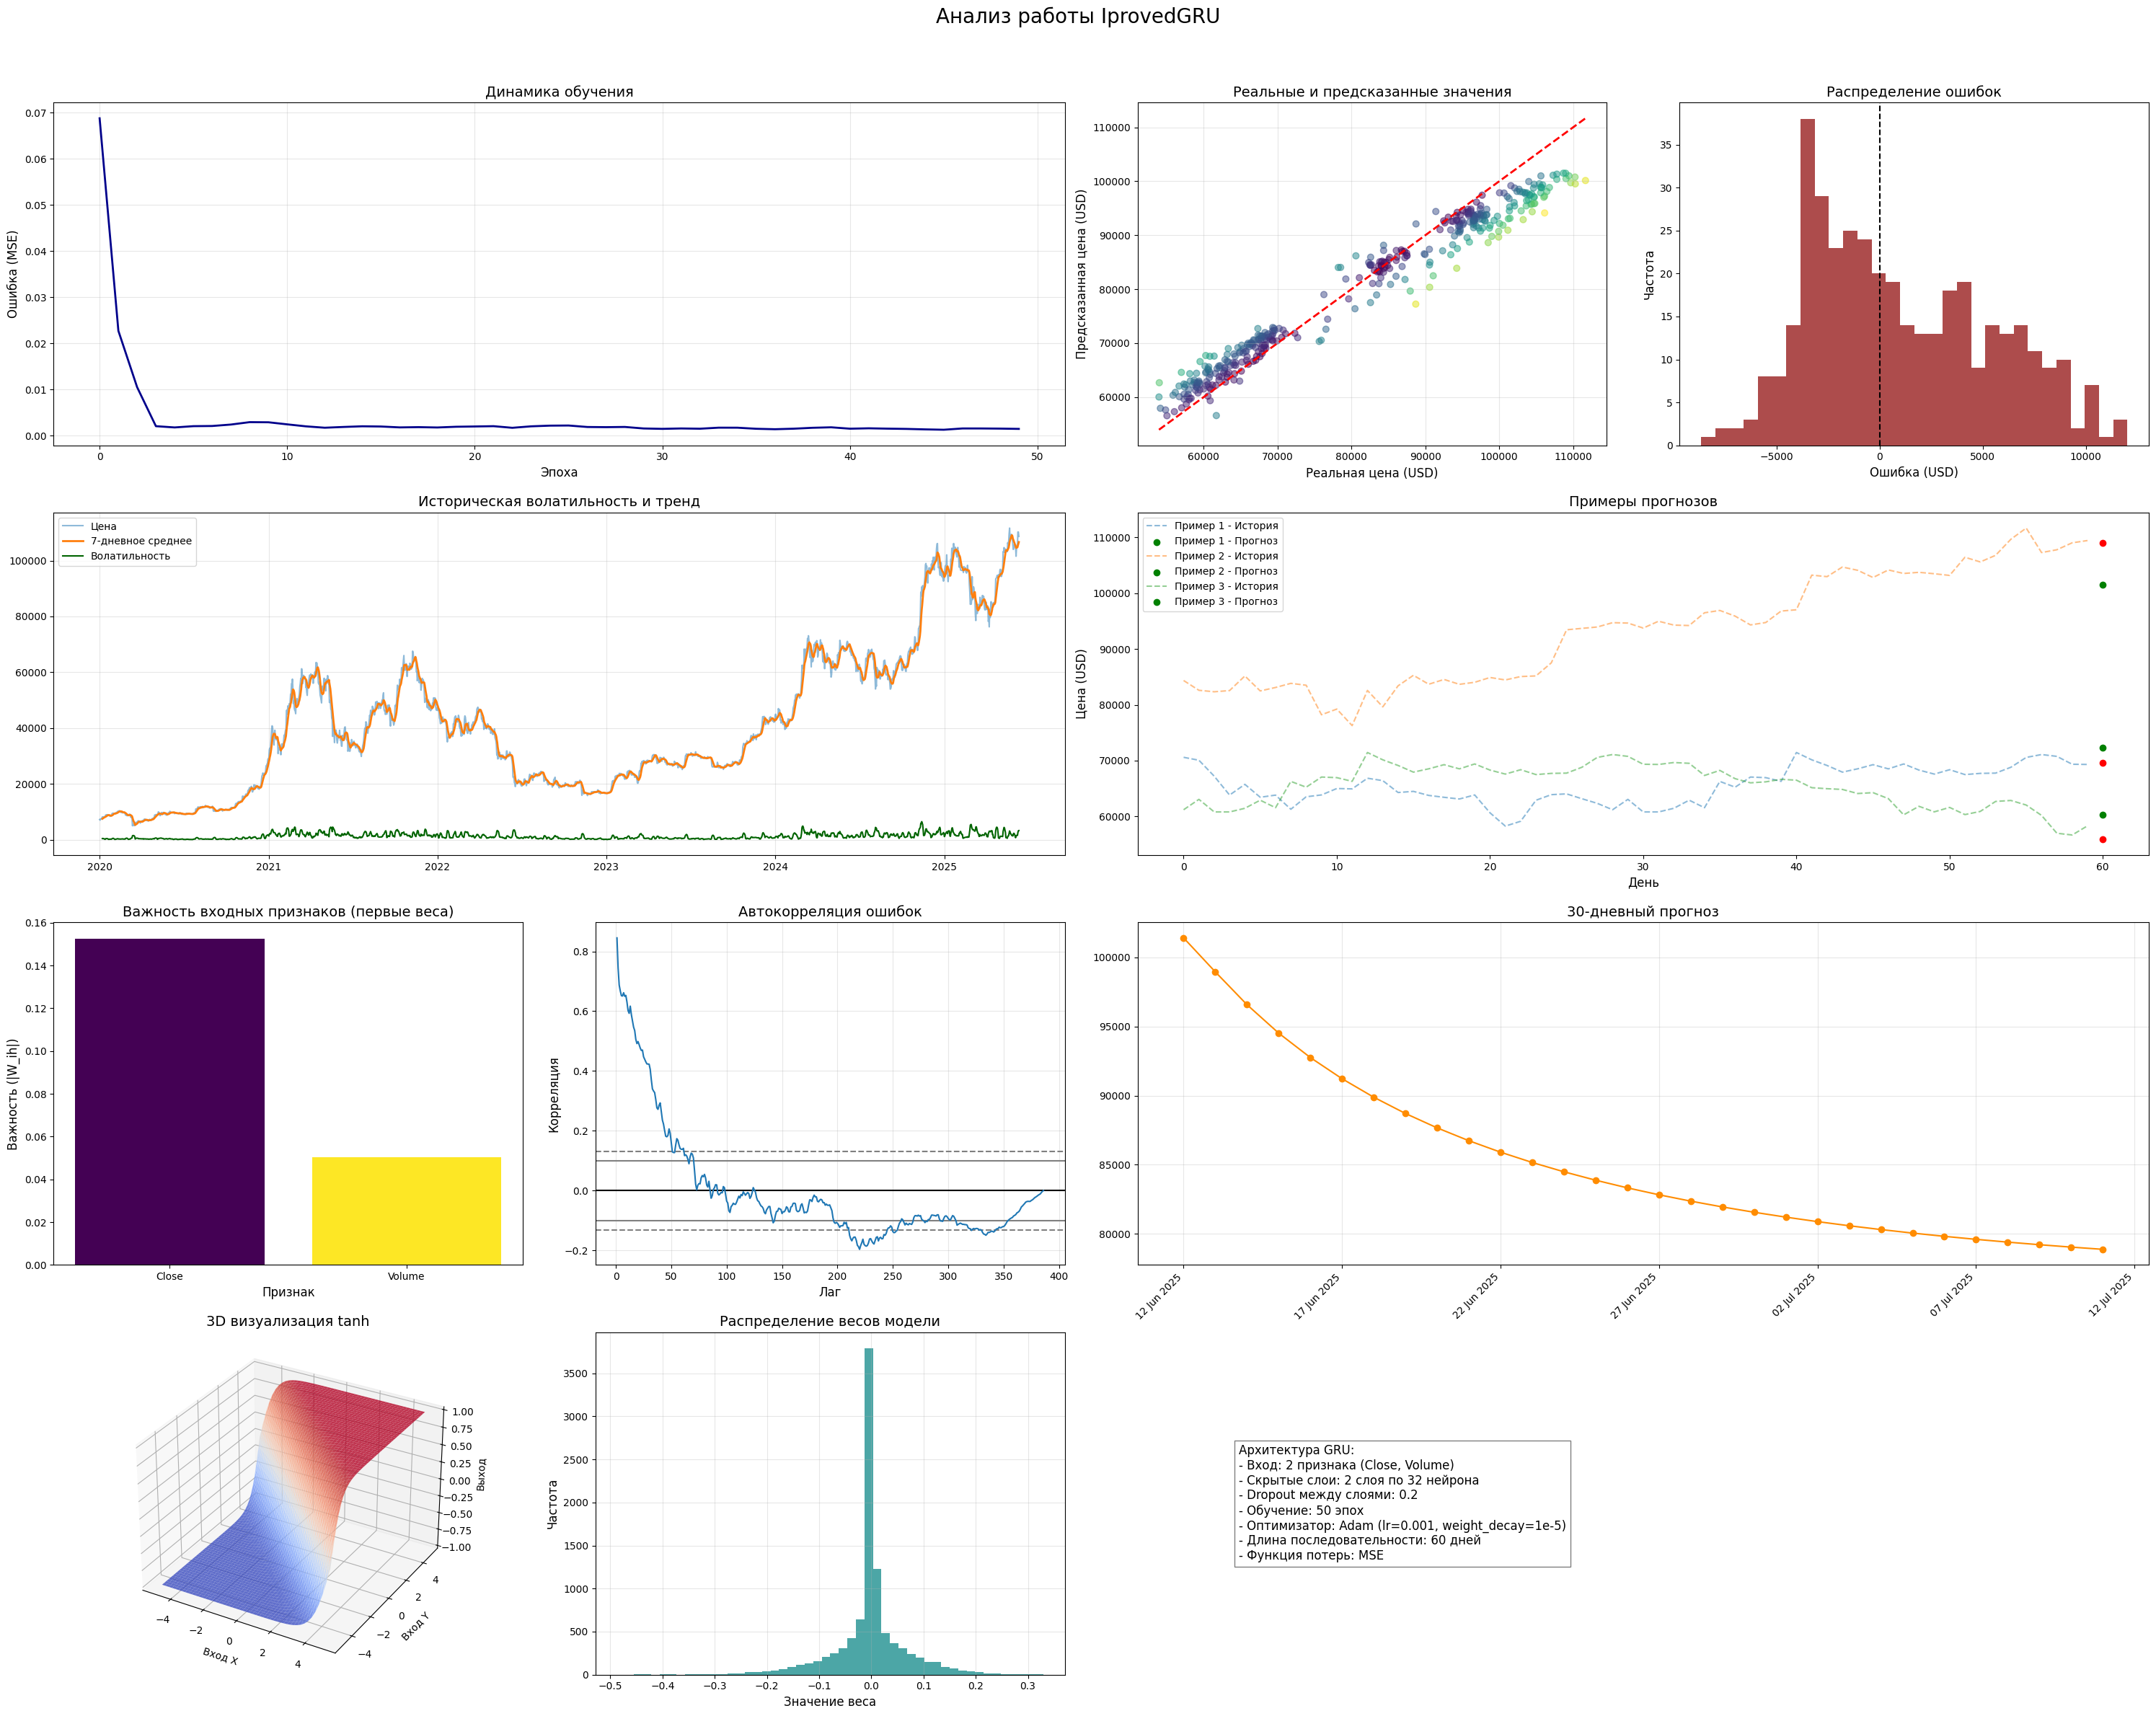

In [3]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category=warn)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start="2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))

# Выбираем цену закрытия и объём торгов
data = data[["Close", "Volume"]]

# Убираем пропуски
data.dropna(inplace=True)

# Масштабирование: обучаем scaler
seq_length = 60
train_ratio = 0.8
n = len(data)
train_size = int(n * train_ratio)

# Чтобы первая тестовая последовательность тоже была полной длины seq_length, оставим в тренировке чуть больше данных
if train_size <= seq_length:
    train_size = seq_length + 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data.iloc[:train_size])
scaled_data = scaler.transform(data)

# Создание последовательностей
def create_sequences(data_array, seq_length):
    X, y = [], []
    for i in range(len(data_array) - seq_length):
        seq = data_array[i:i+seq_length]
        target = data_array[i+seq_length, 0]  # прогнозируем только Close (колонка 0)
        X.append(seq)
        y.append(target)
    return torch.FloatTensor(X), torch.FloatTensor(y)

X, y = create_sequences(scaled_data, seq_length)

# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * train_ratio)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


class IprovedBitcoinGRU(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=2, dropout=0.2):
        super(IprovedBitcoinGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # GRU с двухслойным слоем и dropout между слоями
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = IprovedBitcoinGRU(input_size=X_train.shape[2], hidden_size=32, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # добавлено небольшое L2-регуляризатор

# Обучение модели
num_epochs = 50
train_loss = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Проводим обновление параметров по mini-batch
    batch_size = 16
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        targets = y_train[i:i+batch_size].unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / (len(X_train) / batch_size)
    train_loss.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')

# Функция прогноза
def forecast(model, sequence, days=30):
    model.eval()
    current_seq = sequence.clone().squeeze(0)
    predictions = []
    for _ in range(days):
        pred = model(current_seq.unsqueeze(0))
        pred_val = pred.item()
        predictions.append(pred_val)
        last_vol = current_seq[-1, 1].item()
        new_step = torch.FloatTensor([[pred_val, last_vol]])
        current_seq = torch.cat((current_seq[1:], new_step), dim=0)
    return predictions

# Генерация прогноза
last_sequence = torch.FloatTensor(scaled_data[-seq_length:]).unsqueeze(0)
scaled_forecast = forecast(model, last_sequence, days=30)

# Преобразование предсказаний
close_min = scaler.data_min_[0]; close_max = scaler.data_max_[0]
forecast_prices = np.array(scaled_forecast) * (close_max - close_min) + close_min

# Оценка модели
model.eval()
test_preds_scaled = []
with torch.no_grad():
    for seq in X_test:
        pred = model(seq.unsqueeze(0))
        test_preds_scaled.append(pred.item())

# Инвертируем масштабирование для цен
test_preds = np.array(test_preds_scaled) * (close_max - close_min) + close_min
y_test_scaled = y_test.numpy()
y_test_orig = y_test_scaled * (close_max - close_min) + close_min

# Создание единой фигуры с subplots
plt.figure(figsize=(30, 25))
plt.suptitle("Анализ работы IprovedGRU", y=0.95, fontsize=20)

# 1. График обучения
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
ax1.plot(train_loss, color="darkblue", linewidth=2)
ax1.set_title("Динамика обучения", fontsize=14)
ax1.set_xlabel("Эпоха", fontsize=12)
ax1.set_ylabel("Ошибка (MSE)", fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Сравнение реальных и предсказанных значений
ax2 = plt.subplot2grid((4, 4), (0, 2))
scatter = ax2.scatter(y_test_orig, test_preds, alpha=0.5,
                      c=np.abs(y_test_orig - test_preds), cmap="viridis", s=40)
ax2.plot([y_test_orig.min(), y_test_orig.max()],
         [y_test_orig.min(), y_test_orig.max()],
         "--r", linewidth=2)
ax2.set_title("Реальные и предсказанные значения", fontsize=14)
ax2.set_xlabel("Реальная цена (USD)", fontsize=12)
ax2.set_ylabel("Предсказанная цена (USD)", fontsize=12)
ax2.grid(alpha=0.3)

# 3. Распределение ошибок
ax3 = plt.subplot2grid((4, 4), (0, 3))
errors = y_test_orig - test_preds
ax3.hist(errors, bins=30, color="darkred", alpha=0.7)
ax3.set_title("Распределение ошибок", fontsize=14)
ax3.set_xlabel("Ошибка (USD)", fontsize=12)
ax3.set_ylabel("Частота", fontsize=12)
ax3.axvline(x=0, color="black", linestyle="--")

# 4. Скользящее среднее и волатильность
ax4 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
window_size = 7
data["MA_7"] = data["Close"].rolling(window=window_size).mean()
data["Volatility"] = data["Close"].rolling(window=window_size).std()
ax4.plot(data["Close"], label="Цена", alpha=0.5)
ax4.plot(data["MA_7"], label="7-дневное среднее", linewidth=2)
ax4.plot(data["Volatility"], label="Волатильность", color="darkgreen")
ax4.set_title("Историческая волатильность и тренд", fontsize=14)
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Примеры прогнозов
ax5 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
for i in range(3):
    idx = np.random.randint(len(X_test))
    seq = X_test[idx].numpy()
    with torch.no_grad():
        pred = model(X_test[idx].unsqueeze(0))
    real = y_test_orig[idx]
    ax5.plot(scaler.inverse_transform(seq)[:,0], alpha=0.5, linestyle="--", label=f"Пример {i+1} - История")
    ax5.scatter(len(seq), real, color="red", zorder=5)
    ax5.scatter(len(seq), (pred.item() * (close_max-close_min) + close_min), color="green", zorder=5,
                label=f"Пример {i+1} - Прогноз")
ax5.set_title("Примеры прогнозов", fontsize=14)
ax5.set_xlabel("День", fontsize=12)
ax5.set_ylabel("Цена (USD)", fontsize=12)
ax5.legend()

# 6. Важность входных признаков
ax6 = plt.subplot2grid((4, 4), (2, 0))
gru_weights = model.gru.weight_ih_l0.detach().numpy()
# Усредняем абсолютные веса первых hidden_size строк по каждому признаку
feature_importance = np.mean(np.abs(gru_weights[:model.hidden_size]), axis=0)
features = ["Close", "Volume"]
ax6.bar(range(len(feature_importance)), feature_importance,
        color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
ax6.set_title("Важность входных признаков (первые веса)", fontsize=14)
ax6.set_xlabel("Признак", fontsize=12)
ax6.set_ylabel("Важность (|W_ih|)", fontsize=12)
ax6.set_xticks(range(len(features)))
ax6.set_xticklabels(features)

# 7. Автокорреляция ошибок
ax7 = plt.subplot2grid((4, 4), (2, 1))
pd.plotting.autocorrelation_plot(errors.flatten(), ax=ax7)
ax7.set_title("Автокорреляция ошибок", fontsize=14)
ax7.set_xlabel("Лаг", fontsize=12)
ax7.set_ylabel("Корреляция", fontsize=12)
ax7.grid(alpha=0.3)

# 8. Долгосрочный прогноз
ax8 = plt.subplot2grid((4, 4), (2, 2), colspan=2)
forecast_dates = pd.date_range(start=data.index[-1], periods=31)[1:]
ax8.plot(forecast_dates, forecast_prices, marker="o", markersize=6,
         linestyle="-", color="darkorange")
ax8.set_title("30-дневный прогноз", fontsize=14)
ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
ax8.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.setp(ax8.get_xticklabels(), rotation=45, ha="right")
ax8.grid(True, alpha=0.3)

# 9. 3D визуализация функции активации tanh
ax9 = plt.subplot2grid((4, 4), (3, 0), projection="3d")
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
Xg, Yg = np.meshgrid(x, y)
Z = np.tanh(Xg + Yg)
ax9.plot_surface(Xg, Yg, Z, cmap="coolwarm", alpha=0.8)
ax9.set_title("3D визуализация tanh", fontsize=14)
ax9.set_xlabel("Вход X")
ax9.set_ylabel("Вход Y")
ax9.set_zlabel("Выход")

# 10. Распределение весов модели
ax10 = plt.subplot2grid((4, 4), (3, 1))
all_weights = []
for param in model.parameters():
    if param.requires_grad:
        all_weights.extend(param.detach().numpy().flatten())
ax10.hist(all_weights, bins=50, color="teal", alpha=0.7)
ax10.set_title("Распределение весов модели", fontsize=14)
ax10.set_xlabel("Значение веса", fontsize=12)
ax10.set_ylabel("Частота", fontsize=12)
ax10.grid(True, alpha=0.3)

# 11. Легенда модели
ax11 = plt.subplot2grid((4, 4), (3, 2), colspan=2)
ax11.axis("off")
text = """Архитектура GRU:
- Вход: 2 признака (Close, Volume)
- Скрытые слои: 2 слоя по 32 нейрона
- Dropout между слоями: 0.2
- Обучение: 50 эпох
- Оптимизатор: Adam (lr=0.001, weight_decay=1e-5)
- Длина последовательности: 60 дней
- Функция потерь: MSE"""
ax11.text(0.1, 0.5, text, fontsize=12, va="center", 
          bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


Разберем новые графики:

- Динамика обучения: Плавное уменьшение ошибки
- Реальные и предсказанные значения: Точки практически на прямой `y=x`, видим значительное улучшение по сравнению с лучшей семинарской моделью
- Распределение ошибок: Распределение не совсем близко к нормальному, но видны улучшения по сравнению с прошлой моделью
- Примеры прогнозов: Видим, что в 3 примере явное значение изменило курс, во 2 и 3 примере модель завысила ответ, а вот в 1 - сильно занизила. Не смотря на это, цены приблизительно похожи и мы не видим явных выбросов
- Важность входных признаков: Цена закрытия и объем важны в соотношении примерно `3:1`
- Автокорреляция ошибок: Видим выбросы за пределы доверительного интервала, однако нет повторяющихся шаблонов
- 30-дневный прогноз: Плавное снижение стоимости
- Распределение весов: Заметно красивое симметрично распределение с пиком в нуле

Выводы:

- Удалось значительно улучшить модель
- Можно продолжить пытаться улучшить модель, добавляя в нее разные сигналы, вливая больше информации, как-то реагировать на новости и так далее
- Идеального предсказания не удалось, так как на цену биткоина влияет множество факторов, многие из которых не зависят от прошлой цены - например новости, события в мире, открытия и так далее